In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#42c556;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">FOREST COVER TYPE PREDICTION
</p>
</div> 

<div class="alert alert-warning" role="alert">📌This notebook is begginner friendly and aims at explaining key concepts involved in Forest Cover Type Prediction.I have included feature engineering in this notebook...However my accuracy is better without FE.😅(Things included in this notebook are memory reduction,feature engineering ,accuracy comparision with and without FE and feature importance)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

In [ ]:
train=pd.read_csv('/kaggle/input/tabular-playground-series-dec-2021/train.csv')
test=pd.read_csv('/kaggle/input/tabular-playground-series-dec-2021/test.csv')

In [ ]:
train.drop('Id',axis=1,inplace=True)


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#42c556;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">MEMORY REDUCTION
</p>
</div> 

**> How Does Memory Reduction Help?**🙄
* It helps to avoid memory loss error.That is Running out of RAM to execute your code.

**> How can we reduce memory?**🙄
* Changing Obj Data Type to Categorical.
* To convert a number from one dtype to another ...Keep the following in mind.
    * Number of digits to be stored 
    * Max and min values of the column
    * Kind of precision required 
    
float64 takes two times the memory as compared to float32.However float64’s can represent numbers much more accurately than 32 bit floats.

Difference in bits and resulting difference in precision

* np.array([0.123456789121212,2,3], dtype=np.float16) =0.1235
* np.array([0.123456789121212,2,3], dtype=np.float32)=0.1234567
* np.array([0.123456789121212121212,2,3], dtype=np.float64) =0.12345678912121212


The following link contains the numpy data types and their range
https://www.w3resource.com/numpy/data-types.php


In the below code for each numeric feature(int and float) we first check the min and max values and then see if downsizing the feature is possible


In [ ]:
# Memory before reduction
train.memory_usage().sum() / 1024**2

In [ ]:
def reduce_mem_usage(df, verbose=True):
    #numerics contains various dtypes related to numeric columns
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes # output for this will be something like > dtype('int64')
        if col_type in numerics:
            c_min = df[col].min() # stores minimum val of numeric col
            c_max = df[col].max() # stores maximum val of numeric col
            if str(col_type)[:3] == 'int': # str(col_type)=str(dtype('int64'))='int64' and str(dtype('int64'))[:3]='int'
                # np.iinfo shows limits for various integer types.
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max: # np.iinfo(np.int8) returns an obj iinfo(min=-128, max=127, dtype=int8)
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                #np.finfo shows limits for various float types.
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
# Memory after reduction
train=reduce_mem_usage(train)

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#42c556;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;"> EXPLORATORY DATA ANALYSIS
</p>
</div> 



<div class="alert alert-block alert-info"> 📌 There is a high class imbalance 

In [ ]:
plt.figure(figsize=(10,8))
plt.title('TARGET ANALYSIS:Cover_Type')
train['Cover_Type'].value_counts(normalize=True).plot.bar(color='green')

plt.show()

In [ ]:
for col in soil_types:
    if train[col].value_counts()[0]/len(train)*100>=90:
        print(col,train[col].value_counts()[0]/len(train)*100)

In [ ]:
for col in wilderness:
    if train[col].value_counts()[0]/len(train)*100>=90:
        print(col,train[col].value_counts()[0]/len(train)*100)

<div class="alert alert-block alert-info"> 📌 All soil type columns and two of wilderness columns  are low variance columns🤨 which make them redundant.Let us create a column called **soil_type** which is the sum of all soil type columns  and see if we can increase variability.

In [ ]:
train['soil_type']=train[soil_types].sum(axis=1)
test['soil_type']=test[soil_types].sum(axis=1)

In [ ]:
train.groupby(['soil_type'])['Cover_Type'].agg(pd.Series.mode)

<div class="alert alert-block alert-info"> 📌Even adding the soil types does not increase variability.Let us drop the 40 columns that relate to soil type😶

In [ ]:
cols_drop=[]
cols_drop=soil_types

<div class="alert alert-block alert-info"> 📌 Adding all wilderness columns and dropping the rest.</div>

In [ ]:
train['wildness']=train[wilderness].sum(axis=1)
test['wildness']=test[wilderness].sum(axis=1)

In [ ]:
cols_drop.extend(wilderness)

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#42c556;
           font-size:90%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">TRAIN Vs TEST SET 
</p>
</div> 


In [ ]:
plt.figure()
fig, ax = plt.subplots(figsize=(10,8))



plt.subplot(2,2,1)
plt.title('Wildness_Train')
train['wildness'].value_counts(normalize=True).plot.bar(color='red')

plt.subplot(2,2,2)
plt.title('Wildness_Test')
test['wildness'].value_counts(normalize=True).plot.bar()

plt.show()

In [ ]:
plt.figure()
fig, ax = plt.subplots(figsize=(10,8))
plt.subplot(2,2,1)
plt.title('Soil Type Train')
train['soil_type'].value_counts(normalize=True).plot.bar(color='red')

plt.subplot(2,2,2)
plt.title('Soil Type Test')
test['soil_type'].value_counts(normalize=True).plot.bar()

plt.show()

<div class="alert alert-block alert-info"> 😵 Train And Test Set Seem to be Different.</div>

<div class="alert alert-warning" role="alert">📌Aspect(Azimuth) identifies the downslope direction of the maximum rate of change in value from each cell to its neighbors. It can be thought of as the slope direction. The values of each cell in the output raster indicate the compass direction that the surface faces at that location. It is measured clockwise in degrees from 0 (due north) to 360 (again due north), coming full circle.The azimuth angle value will be negative before solar noon, and positive after solar noon.

[Click Here To Read More On aspect](https://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/how-aspect-works.htm)

In [ ]:
train.Aspect.describe()

**What to do when aspect is negative?**🙄
Simply add 360  [As per wikipedia link](www.google.com/search?q=can+you+have+a+negative+azimuth+The+formula+in+radians+would+be+slightly+easier%3A.&sxsrf=AOaemvLT-9tmWJcc3X6p27oAv2VysQPXLQ%3A1639839527750&ei=J_e9YYuWLcKpoATYo6iYDA&ved=0ahUKEwjLxaikzu30AhXCFIgKHdgRCsMQ4dUDCA4&uact=5&oq=can+you+have+a+negative+azimuth+The+formula+in+radians+would+be+slightly+easier%3A.&gs_lcp=Cgdnd3Mtd2l6EAM6BwgjELADECc6BwgAEEcQsAM6BggAEBYQHkoECEEYAEoECEYYAFCZAVikCGDPDGgBcAJ4AIABeYgB4gGSAQMwLjKYAQCgAQGgAQLIAQnAAQE&sclient=gws-wiz)


In [ ]:
train["Aspect"][train["Aspect"] < 0] += 360
train["Aspect"][train["Aspect"] > 359] -= 360

test["Aspect"][test["Aspect"] < 0] += 360
test["Aspect"][test["Aspect"] > 359] -= 360

<div class="alert alert-warning" role="alert">📌Hillshading is the process of adding light and dark areas or shading to a map to highlight the location of hills or mountains. Hillshading uses light and dark areas to highlight where sunlight would hit and where shadows would form in the presence of hills and mountains.(Range 0-255)

In [ ]:
train[['Hillshade_Noon','Hillshade_9am','Hillshade_3pm']].describe()

<div class="alert alert-block alert-info"> 📌 Getting hillshade values in the range.</div>

In [ ]:
train.loc[train["Hillshade_9am"] < 0, "Hillshade_9am"] = 0
train.loc[train["Hillshade_Noon"] < 0, "Hillshade_Noon"] = 0
train.loc[train["Hillshade_3pm"] < 0, "Hillshade_3pm"] = 0
train.loc[train["Hillshade_9am"] > 255, "Hillshade_9am"] = 255
train.loc[train["Hillshade_Noon"] > 255, "Hillshade_Noon"] = 255
train.loc[train["Hillshade_3pm"] > 255, "Hillshade_3pm"] = 255


test.loc[test["Hillshade_9am"] < 0, "Hillshade_9am"] = 0
test.loc[test["Hillshade_Noon"] < 0, "Hillshade_Noon"] = 0
test.loc[test["Hillshade_3pm"] < 0, "Hillshade_3pm"] = 0
test.loc[test["Hillshade_9am"] > 255, "Hillshade_9am"] = 255
test.loc[test["Hillshade_Noon"] > 255, "Hillshade_Noon"] = 255
test.loc[test["Hillshade_3pm"] > 255, "Hillshade_3pm"] = 255

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#42c556;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;"> HOW FEATURES VARY WITH COVER TYPE
</p>
</div> 

In [ ]:
plt.figure()

fig, ax = plt.subplots(figsize=(15,15))
plt.subplot(3,3,1)
sns.boxplot(x=train['Cover_Type'],y=train['Aspect'])
plt.title("Aspect vs Cover Type")

plt.subplot(3,3,2)
sns.boxplot(x=train['Cover_Type'],y=train['Elevation'])
plt.title('Elevation vs Cover Type')

plt.subplot(3,3,3)
sns.boxplot(x=train['Cover_Type'],y=train['Slope'])
plt.title('Slope vs Cover Type')

plt.subplot(3,3,4)
sns.boxplot(x=train['Cover_Type'],y=train['Horizontal_Distance_To_Hydrology'])
plt.title('Horizontal_Distance_To_Hydrology vs Cover Type')

plt.subplot(3,3,5)
sns.boxplot(x=train['Cover_Type'],y=train['Vertical_Distance_To_Hydrology'])
plt.title('Vertical_Distance_To_Hydrology vs Cover Type')

plt.subplot(3,3,6)
sns.boxplot(x=train['Cover_Type'],y=train['Horizontal_Distance_To_Roadways'])
plt.title('Horizontal_Distance_To_Roadways vs Cover Type')

plt.subplot(3,3,7)
sns.boxplot(x=train['Cover_Type'],y=train['Hillshade_9am'])
plt.title('Hillshade_9am vs Cover Type')

plt.subplot(3,3,8)
sns.boxplot(x=train['Cover_Type'],y=train['Hillshade_Noon'])
plt.title('Hillshade_Noon vs Cover Type')

plt.subplot(3,3,9)
sns.boxplot(x=train['Cover_Type'],y=train['Hillshade_3pm'])
plt.title('Hillshade_3pm vs Cover Type')




plt.show()

<div class="alert alert-block alert-info">📌 Elevation seems to be a good predictor of Cover Type.</div>

In [ ]:
train[['Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways','Horizontal_Distance_To_Fire_Points']].describe()

<div class="alert alert-block alert-info">📌 Distance cannot be negative.What does horizontal and vertical distance remind you of?😳....Pythagoras theorem?...Eureka!!!😮...Lets create a new feature Distance to Hyderology</div>



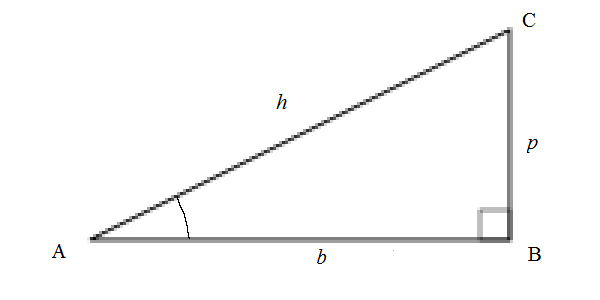

-  Where AC is hyderological distance

In [ ]:
train['Hydrological_Distance']=(train['Horizontal_Distance_To_Hydrology']**2+train['Vertical_Distance_To_Hydrology']**2)**0.5
test['Hydrological_Distance'] = (test['Horizontal_Distance_To_Hydrology']**2+test['Vertical_Distance_To_Hydrology']**2)**0.5

In [ ]:
cols_drop.extend(['Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology'])

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#42c556;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;"> SIMPLE XGBOOST MODEL
</p>
</div> 

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
X=train.drop('Cover_Type',axis=True)
Y=train['Cover_Type']

In [ ]:
X_train,x_test,Y_train,y_test=train_test_split(X,Y,train_size=0.70)

In [ ]:
# Training a model without removing drop cols

xgb_without_fe=XGBClassifier(n_estimators=95,n_jobs=-1,booster='gbtree',predictor='gpu_predictor',tree_method='gpu_hist')
xgb_without_fe.fit(X_train,Y_train)
predicted_value=xgb_without_fe.predict(x_test)
acc_score_without_fe=accuracy_score(y_test,predicted_value)
acc_score_without_fe

In [ ]:
# Training a model after removing drop cols
X_train_drop_cols=X_train.drop(cols_drop,axis=1)
x_test_drop_cols=x_test.drop(cols_drop,axis=1)


xgb_with_fe=XGBClassifier(n_estimators=95,n_jobs=-1,booster='gbtree',predictor='gpu_predictor',tree_method='gpu_hist')
xgb_with_fe.fit(X_train_drop_cols,Y_train)
predicted_value=xgb_with_fe.predict(x_test_drop_cols)
acc_score_with_fe=accuracy_score(y_test,predicted_value)
acc_score_with_fe

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#42c556;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;"> ACCURACY COMPARISON WITH AND WITHOUT FE
</p>
</div> 

In [ ]:
compare=pd.DataFrame({'With_Fe':acc_score_with_fe,'Without_Fe':acc_score_without_fe},index=range(1))
compare

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#42c556;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;"> FEATURE IMPORTANCE
</p>
</div> 

In [ ]:
from xgboost import plot_importance
from matplotlib import pyplot

In [ ]:
plot_importance(xgb_without_fe, max_num_features=10) # top 10 most important features
plt.show()

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#42c556;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;"> SUBMISSION
</p>
</div> 

In [ ]:
test_id=test['Id']
test.drop('Id',inplace=True,axis=1)

In [ ]:
test=test[X_train.columns]

In [ ]:
predicted_value=xgb_without_fe.predict(test)
submission=pd.DataFrame({'Id':test_id,'Cover_Type':predicted_value})

In [ ]:
submission.set_index('Id')

In [ ]:
pd.read_csv('submission.csv')